# Fama-French Factor Analysis of Trading Strategies

## Overview
This notebook performs a comprehensive factor analysis of proprietary trading strategies using the Fama-French multi-factor models. The analysis evaluates whether the strategies generate statistically significant alpha (excess returns) after accounting for systematic risk factors.

## Methodology

### Data Sources
- **Strategy Returns**: Daily returns from proprietary trading accounts (2023-2025)
- **Benchmark**: S&P 500 (SPY) daily returns
- **Factor Data**: AQR Capital Management's Fama-French factor datasets
  - Market factor (MKT): Market risk premium
  - Size factor (SMB): Small Minus Big
  - Value factor (HML): High Minus Low
  - Momentum factor (UMD): Up Minus Down
  - Quality factor (QMJ): Quality Minus Junk
  - Beta factor (BAB): Betting Against Beta
- **Risk-Free Rate**: Monthly risk-free rate from AQR datasets

### Analysis Framework
1. **Data Preparation**: Convert daily returns to monthly frequency to match factor data
2. **Excess Returns**: Calculate strategy returns minus risk-free rate
3. **Factor Regressions**: Run multiple regression models:
   - CAPM (1-factor): Market only
   - Fama-French 4-factor: Market, Size, Value, Momentum
   - Fama-French 6-factor: Adding Quality and Beta factors

### Key Metrics
- **Alpha**: Intercept from factor regressions (annualized) - represents returns not explained by factor exposure
- **Factor Loadings**: Coefficients showing strategy sensitivity to each risk factor
- **R-squared**: Proportion of strategy returns explained by the factor model
- **Statistical Significance**: T-statistics and p-values for alpha and factor exposures

## Expected Results
The analysis will determine:
1. Whether strategies generate significant alpha after controlling for known risk factors
2. Which factors drive strategy performance
3. How much of strategy returns can be explained by systematic factor exposures
4. The risk-adjusted performance comparison with passive benchmarks

## Key Findings
Results will be displayed in regression tables below, with particular focus on:
- The alpha coefficient (excess return generation)
- Factor exposures (market beta, size tilt, value/growth orientation, etc.)
- Model fit quality (R-squared values)
- Statistical significance of findings

---

## Understanding Return Metrics in Factor Analysis

This section clarifies the key differences between the return metrics used in our factor regressions and their interpretations.

### Monthly Returns vs Excess Returns

**Monthly Returns (`monthly_returns_strategies`)**
- Raw monthly returns of the trading strategies
- Calculated by compounding daily returns within each month: $(1 + r_1) \times (1 + r_2) \times ... \times (1 + r_n) - 1$
- Represents the total percentage gain or loss for the month
- **Does NOT account for the risk-free rate** (opportunity cost of capital)
- Used in basic performance analysis but not appropriate for factor model regressions

**Excess Returns (`excess_returns_strategies`)**
- Monthly returns minus the risk-free rate: $R_{excess} = R_{strategy} - R_f$
- Represents returns **above the risk-free alternative** (e.g., Treasury bills)
- This is the theoretically correct metric for factor analysis because:
  - Investors care about returns above what they could earn risk-free
  - Factor premiums represent compensation for bearing systematic risk
  - Allows direct comparison of risk-adjusted performance

### Why Two Different Regressions?

**Regression 1: `monthly_returns_strategies ~ Factors`**
- Uses raw monthly returns as the dependent variable
- **Alpha interpretation**: The intercept represents the average monthly return not explained by factor exposures
- However, this alpha includes the risk-free rate component
- Less theoretically rigorous but easier to interpret in absolute terms

**Regression 2: `excess_returns_strategies ~ Factors`**
- Uses excess returns (returns minus risk-free rate) as the dependent variable
- **Alpha interpretation**: The intercept represents **true alpha** - the excess return above both the risk-free rate AND what the factor model predicts
- This is the **correct specification** according to modern portfolio theory
- Alpha here directly measures skill/value-added by the strategy

### Key Differences in Interpretation

| Metric | Formula | Alpha Meaning | Use Case |
|--------|---------|---------------|----------|
| Monthly Returns | $R_{strategy}$ | Return not explained by factors (includes risk-free rate) | Descriptive analysis |
| Excess Returns | $R_{strategy} - R_f$ | True alpha (pure skill above risk-free rate and factor exposures) | Formal factor analysis |

### Practical Implications

1. **Both regressions will show similar factor loadings** (betas) since the risk-free rate is constant across observations
2. **Alpha estimates will differ** by approximately the average risk-free rate over the period
3. **R-squared values** should be nearly identical since subtracting a constant doesn't change explained variance
4. **For academic and professional analysis**, always use excess returns to properly isolate alpha from the risk-free rate

### What We're Testing

In both cases, we're asking: "After accounting for systematic factor exposures (market, size, value, momentum, quality, beta), does the strategy still generate returns?"

- If alpha is **positive and statistically significant**: Strategy adds value beyond factor exposures
- If alpha is **near zero**: Strategy returns are fully explained by factor tilts (e.g., just taking market risk)
- If alpha is **negative**: Strategy underperforms after accounting for risk factors (destroys value)

In [73]:
# from pandas_datareader import data

import requests
import io

In [74]:
# Imports & Settings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import dateutil.parser
"""
parser.parse() automatically detects many date formats without you specifying the format string.
It returns a datetime.datetime object.
You can pass dayfirst=True if your dates are in DD/MM/YYYY format
"""

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load environment variables
from dotenv import load_dotenv
import os
from pathlib import Path

# Load .env file from current directory
env_path = Path('.env')
load_dotenv(env_path);

In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [76]:
# Get path from environment variables
path_daily_returns_strategies = os.getenv('path_daily_returns_strategies')

# Full History for all the strategies
path = path_daily_returns_strategies
# print(f"Data file path: {path}")

# read csv file from path
df = pd.read_csv(path, sep=';') 

df.head()

,Date,Profit_pct_100
0,2023-04-17,0.05
1,2023-04-18,-0.00
2,2023-04-19,-0.01
3,2023-04-20,-0.00
4,2023-04-21,0.00


In [77]:
# Get path from environment variables
path_daily_returns_strategies = os.getenv('path_daily_returns_strategies')
path_daily_returns_spy = os.getenv('path_daily_returns_spy')

daily_returns_spy = pd.read_csv(path_daily_returns_spy, index_col=0, parse_dates=True, sep=';')
daily_returns_strategies = pd.read_csv(path_daily_returns_strategies, index_col=0, parse_dates=True, sep=';')

# Fix: Normalize dates to remove time component
daily_returns_spy.index = daily_returns_spy.index.normalize()
daily_returns_strategies.index = daily_returns_strategies.index.normalize()
# rename the columns
daily_returns_spy.columns = ['daily_returns_spy']
daily_returns_strategies.columns = ['daily_returns_strategies']

In [78]:
print(daily_returns_spy.head())
print(daily_returns_strategies.head())

            daily_returns_spy
datetime                     
2023-04-19                NaN
2023-04-20              -0.01
2023-04-21               0.00
2023-04-24               0.00
2023-04-25              -0.02
            daily_returns_strategies
Date                                
2023-04-17                      0.05
2023-04-18                     -0.00
2023-04-19                     -0.01
2023-04-20                     -0.00
2023-04-21                      0.00


In [79]:
# merge the two dataframes on the index (now with normalized dates)
merged_df = pd.merge(daily_returns_spy, daily_returns_strategies, left_index=True, right_index=True, how='inner')

# drop na values
merged_df = merged_df.dropna()

print(f"Merged DataFrame shape: {merged_df.shape}")
merged_df.head()

Merged DataFrame shape: (577, 2)


,daily_returns_spy,daily_returns_strategies
2023-04-20,-0.01,-0.00
2023-04-21,0.00,0.00
2023-04-24,0.00,-0.01
2023-04-26,-0.00,0.06
2023-04-28,0.01,0.00


In [80]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 577 entries, 2023-04-20 to 2025-10-31
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   daily_returns_spy         577 non-null    float64
 1   daily_returns_strategies  577 non-null    float64
dtypes: float64(2)
memory usage: 13.5 KB


In [81]:
# merged_df have daily returns for both SPY and strategies, indexed by date
# we need to compute the returns and grop them by month to match Fama-French data frequency
# last day of month for each date in the index

# add last day of month column
merged_df['Date'] = merged_df.index.to_period('M').to_timestamp('M')

# group by month and compute daily returns to monthly returns, adding two new columns
merged_df['monthly_returns_spy'] = merged_df.groupby('Date')['daily_returns_spy'].apply(lambda x: (1 + x).prod() - 1)
merged_df['monthly_returns_strategies'] = merged_df.groupby('Date')['daily_returns_strategies'].apply(lambda x: (1 + x).prod() - 1)

# drop na values
merged_df = merged_df.dropna()

merged_df.head()

,daily_returns_spy,daily_returns_strategies,Date,monthly_returns_spy,monthly_returns_strategies
2023-06-30,0.01,-0.00,2023-06-30,0.08,0.03
2023-08-31,-0.00,0.02,2023-08-31,-0.01,-0.00
2023-10-31,0.01,0.00,2023-10-31,-0.02,0.02
2023-11-30,0.00,-0.01,2023-11-30,0.07,0.18
2024-01-31,-0.02,-0.05,2024-01-31,0.02,-0.11


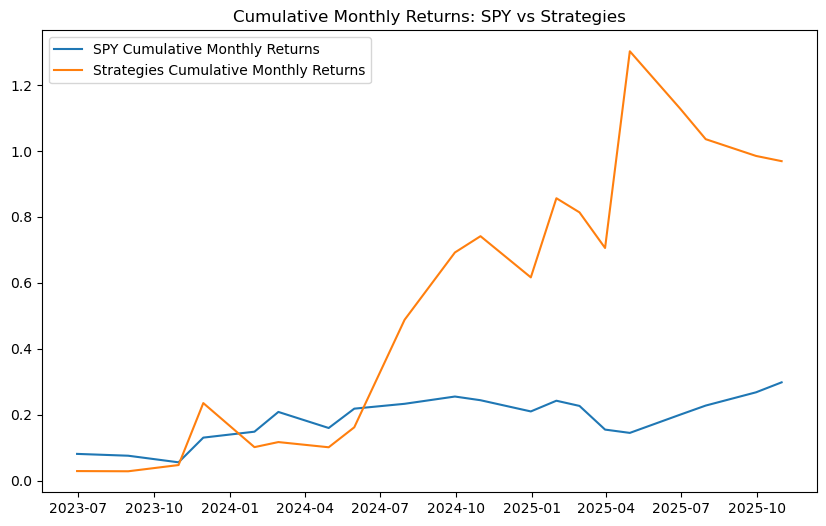

In [82]:
# visualization purpose only
# add two columns with compounded monthly returns
merged_df['cum_returns_spy'] = (1 + merged_df['monthly_returns_spy']).cumprod() - 1
merged_df['cum_returns_strategies'] = (1 + merged_df['monthly_returns_strategies']).cumprod() - 1

# plot merged_df.cum_returns_spy  
plt.figure(figsize=(10, 6))
plt.plot(merged_df.index, merged_df['cum_returns_spy'], label='SPY Cumulative Monthly Returns')
plt.plot(merged_df.index, merged_df['cum_returns_strategies'], label='Strategies Cumulative Monthly Returns')
plt.title('Cumulative Monthly Returns: SPY vs Strategies') 
plt.legend()
plt.show()

In [83]:
url_qmj = "https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Quality-Minus-Junk-Factors-Monthly.xlsx"
url_bab = "https://www.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Betting-Against-Beta-Equity-Factors-Monthly.xlsx"

In [84]:
response = requests.get(url_qmj)
f = io.BytesIO(response.content)

In [85]:
# Quality-Minus-Junk Factors Monthly
df_qmj=pd.read_excel(io=f, sheet_name='QMJ Factors', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'QMJ'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_qmj_ = df_qmj.copy()
df_qmj.head()

,DATE,QMJ
0,1957-07-31,0.01
1,1957-08-31,0.00
2,1957-09-30,0.01
3,1957-10-31,0.00
4,1957-11-30,-0.01


In [86]:
response = requests.get(url_bab)
f = io.BytesIO(response.content)

In [87]:
# Betting-Against-Beta Equity Factors Monthly
df_bab = pd.read_excel(io=f, sheet_name='BAB Factors', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'BAB'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_bab_ = df_bab.copy()
df_bab_.head()

,DATE,BAB
0,1930-12-31,-0.00
1,1931-01-31,-0.02
2,1931-02-28,-0.08
3,1931-03-31,0.03
4,1931-04-30,-0.01


In [88]:
# HML High Minus Low Equity Factors Monthly
df_hml = pd.read_excel(io=f, sheet_name='HML FF', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'HML'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_hml_ = df_hml.copy()
df_hml_.head()

,DATE,HML
0,1926-07-31,-0.03
1,1926-08-31,0.05
2,1926-09-30,-0.01
3,1926-10-31,0.01
4,1926-11-30,0.00


In [89]:
# SMB Small Minus Big Equity Factors Monthly
df_smb = pd.read_excel(io=f, sheet_name='SMB', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'SMB'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_smb_ = df_smb.copy()
df_smb_.head()

,DATE,SMB
0,1926-07-31,-0.02
1,1926-08-31,-0.01
2,1926-09-30,-0.01
3,1926-10-31,0.01
4,1926-11-30,-0.01


In [90]:
# UMD Up Minus Down Equity Factors Monthly
df_umd = pd.read_excel(io=f, sheet_name='UMD', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'UMD'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_umd_ = df_umd.copy()
df_umd_.head()

,DATE,UMD
0,1927-01-31,0.03
1,1927-02-28,-0.01
2,1927-03-31,0.05
3,1927-04-30,0.03
4,1927-05-31,0.05


In [91]:
# Risk Free Rate Monthly
df_rfr = pd.read_excel(io=f, sheet_name='RF', skiprows=18, usecols="A:B")[['DATE', 'Risk Free Rate']].rename(columns={'Risk Free Rate': 'RF'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_rfr_ = df_rfr.copy()
df_rfr_.head()

,DATE,RF
0,1926-07-31,0.00
1,1926-08-31,0.00
2,1926-09-30,0.00
3,1926-10-31,0.00
4,1926-11-30,0.00


In [92]:
# Market Equity Factors Monthly
df_mkt = pd.read_excel(io=f, sheet_name='MKT', skiprows=18, usecols="A:Y")[['DATE', 'USA']].rename(columns={'USA': 'MKT'}).assign(DATE=lambda x: x['DATE'].apply(lambda y: dateutil.parser.parse(y)))
df_mkt_ = df_mkt.copy()
df_mkt_.head()

,DATE,MKT
0,1926-07-31,0.03
1,1926-08-31,0.03
2,1926-09-30,0.00
3,1926-10-31,-0.03
4,1926-11-30,0.02


In [93]:
# merging all dfs
model_data = (
    merged_df
    .reset_index()
    .rename(columns={'index': 'DATE'})
    .merge(df_rfr, how='inner', on='DATE')
    .merge(df_mkt, how='inner', on='DATE')
    .merge(df_hml, how='inner', on='DATE')
    .merge(df_smb, how='inner', on='DATE')
    .merge(df_umd, how='inner', on='DATE')
    .merge(df_qmj, how='inner', on='DATE')
    .merge(df_bab, how='inner', on='DATE')
)

# drop columns daily_returns_spy, daily_returns_strategies, DATE, cum_returns_spy, cum_returns_strategies
model_data = model_data.drop(columns=['daily_returns_spy', 'daily_returns_strategies', 'DATE', 'cum_returns_spy', 'cum_returns_strategies'])

model_data.head()

,Date,monthly_returns_spy,monthly_returns_strategies,RF,MKT,HML,SMB,UMD,QMJ,BAB
0,2023-06-30,0.08,0.03,0.00,0.07,-0.01,0.01,-0.03,-0.01,-0.01
1,2023-08-31,-0.01,-0.00,0.00,-0.03,-0.01,-0.02,0.04,0.04,0.02
2,2023-10-31,-0.02,0.02,0.00,-0.03,-0.00,-0.04,0.03,0.04,0.04
3,2023-11-30,0.07,0.18,0.00,0.09,0.00,0.00,0.02,-0.03,-0.01
4,2024-01-31,0.02,-0.11,0.00,0.00,-0.01,-0.04,0.05,-0.00,0.01


In [94]:
model_data.tail()

,Date,monthly_returns_spy,monthly_returns_strategies,RF,MKT,HML,SMB,UMD,QMJ,BAB
15,2025-04-30,-0.01,0.35,0.00,-0.01,-0.04,-0.00,0.03,-0.02,-0.03
16,2025-06-30,0.05,-0.08,0.00,0.05,-0.01,0.01,-0.02,-0.04,-0.03
17,2025-07-31,0.02,-0.04,0.00,0.02,-0.01,0.01,-0.02,-0.01,-0.01
18,2025-09-30,0.03,-0.02,0.00,0.03,-0.02,-0.01,0.02,-0.07,-0.02
19,2025-10-31,0.02,-0.01,0.00,0.01,-0.03,-0.00,0.00,-0.04,-0.04


In [95]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        20 non-null     datetime64[ns]
 1   monthly_returns_spy         20 non-null     float64       
 2   monthly_returns_strategies  20 non-null     float64       
 3   RF                          20 non-null     float64       
 4   MKT                         20 non-null     float64       
 5   HML                         20 non-null     float64       
 6   SMB                         20 non-null     float64       
 7   UMD                         20 non-null     float64       
 8   QMJ                         20 non-null     float64       
 9   BAB                         20 non-null     float64       
dtypes: datetime64[ns](1), float64(9)
memory usage: 1.7 KB


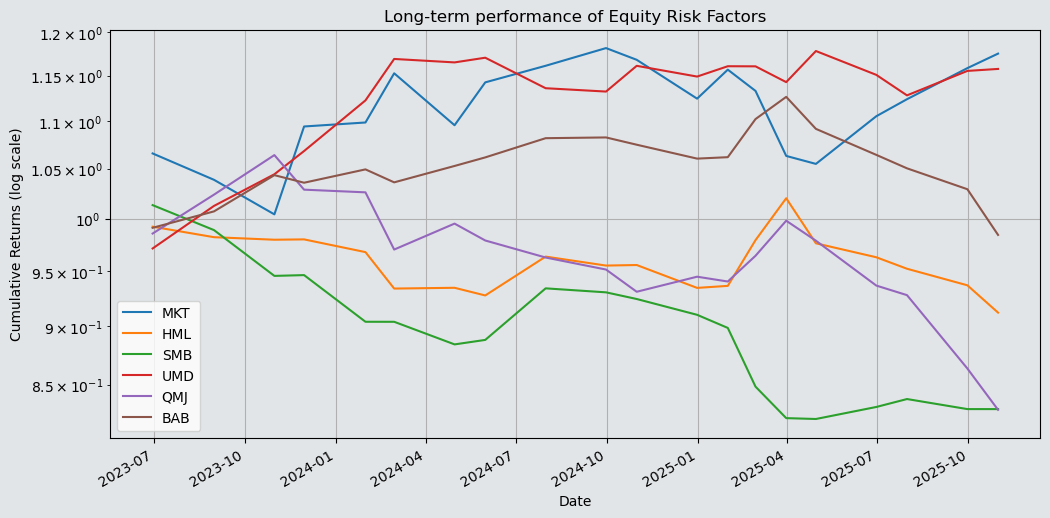

In [96]:
# Plot cumulative performance of risk factors
ax = (
    model_data
    .set_index('Date')
    [['MKT', 'HML', 'SMB', 'UMD', 'QMJ', 'BAB']]
    .apply(lambda x: (1 + x).cumprod())
    .plot(figsize=(12, 6))
)
ax.set_facecolor('#E2E5E8')
fig = ax.get_figure()
fig.set_facecolor('#E2E5E8') 
plt.grid()
plt.yscale("log")
plt.title('Long-term performance of Equity Risk Factors')
plt.ylabel('Cumulative Returns (log scale)')
plt.xlabel('Date')
plt.show()

In [97]:
# Create excess returns: Strategy returns minus risk-free rate
model_data['excess_returns_strategies'] = model_data['monthly_returns_strategies'] - model_data['RF']
model_data['excess_returns_spy'] = model_data['monthly_returns_spy'] - model_data['RF']

model_data.head()

,Date,monthly_returns_spy,monthly_returns_strategies,RF,MKT,HML,SMB,UMD,QMJ,BAB,excess_returns_strategies,excess_returns_spy
0,2023-06-30,0.08,0.03,0.00,0.07,-0.01,0.01,-0.03,-0.01,-0.01,0.02,0.08
1,2023-08-31,-0.01,-0.00,0.00,-0.03,-0.01,-0.02,0.04,0.04,0.02,-0.00,-0.01
2,2023-10-31,-0.02,0.02,0.00,-0.03,-0.00,-0.04,0.03,0.04,0.04,0.01,-0.02
3,2023-11-30,0.07,0.18,0.00,0.09,0.00,0.00,0.02,-0.03,-0.01,0.18,0.07
4,2024-01-31,0.02,-0.11,0.00,0.00,-0.01,-0.04,0.05,-0.00,0.01,-0.11,0.01


In [98]:
model_data.RF.unique()

array([0.00438333, 0.0044    , 0.00443333, 0.00444167, 0.00433333,
       0.00435   , 0.00435833, 0.004375  , 0.00415   , 0.00376667,
       0.00365833, 0.003525  , 0.0035    , 0.00350833, 0.00354167,
       0.00353333, 0.003375  , 0.00321667])

In [99]:
# Regression: Strategy excess returns vs Fama-French factors
X = model_data[['MKT', 'HML', 'SMB', 'UMD', 'QMJ', 'BAB']]
y = model_data['excess_returns_strategies']
X = sm.add_constant(X)  # add constant term for intercept (alpha)

model = sm.OLS(y, X).fit()
print(model.summary())

# Extract alpha
alpha_monthly = model.params['const']
alpha_annualized = alpha_monthly * 12

print(f"\nMonthly Alpha: {alpha_monthly:.4f} ({alpha_monthly*100:.2f}%)")
print(f"Annualized Alpha: {alpha_annualized:.4f} ({alpha_annualized*100:.2f}%)")

                                OLS Regression Results                               
Dep. Variable:     excess_returns_strategies   R-squared:                       0.455
Model:                                   OLS   Adj. R-squared:                  0.204
Method:                        Least Squares   F-statistic:                     1.810
Date:                       Mon, 29 Dec 2025   Prob (F-statistic):              0.174
Time:                               15:27:46   Log-Likelihood:                 20.532
No. Observations:                         20   AIC:                            -27.06
Df Residuals:                             13   BIC:                            -20.09
Df Model:                                  6                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

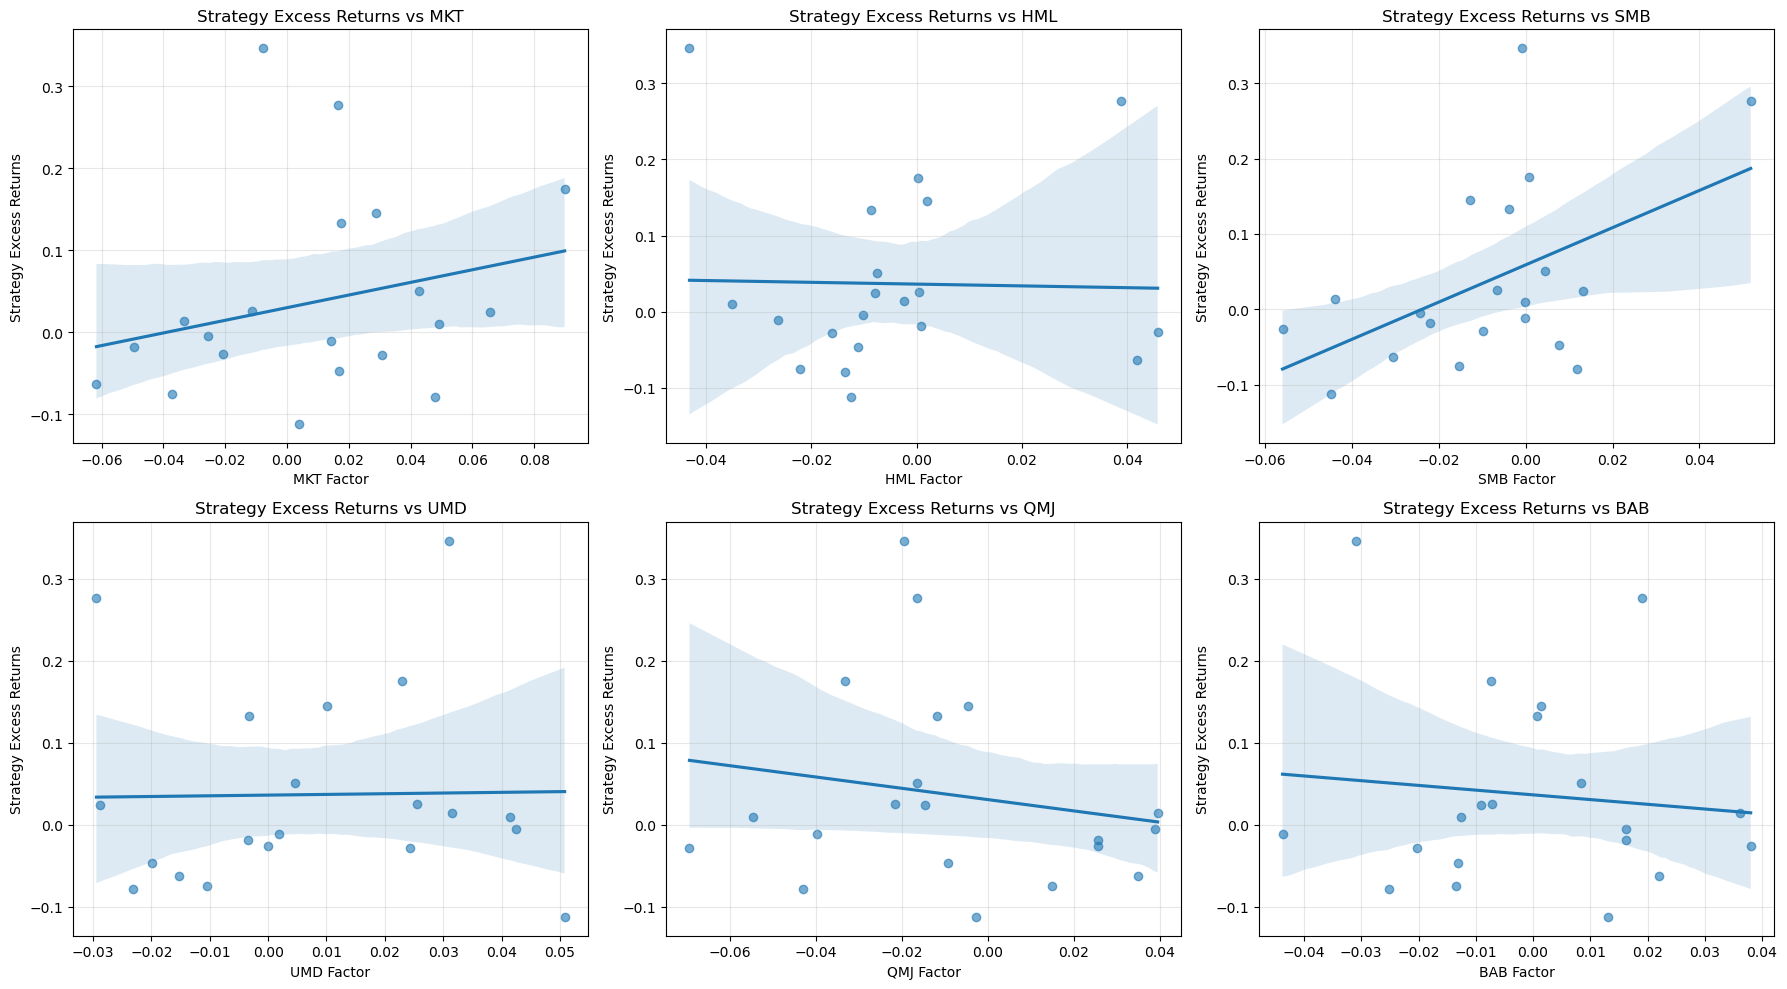

In [100]:
# Scatter Regression Plot: Strategy excess returns vs all Fama-French factors
factors = ['MKT', 'HML', 'SMB', 'UMD', 'QMJ', 'BAB']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, factor in enumerate(factors):
    ax = axes[idx]
    sns.regplot(data=model_data, x=factor, y='excess_returns_strategies', ax=ax, scatter_kws={'alpha': 0.6})
    ax.set_title(f'Strategy Excess Returns vs {factor}')
    ax.set_xlabel(f'{factor} Factor')
    ax.set_ylabel('Strategy Excess Returns')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

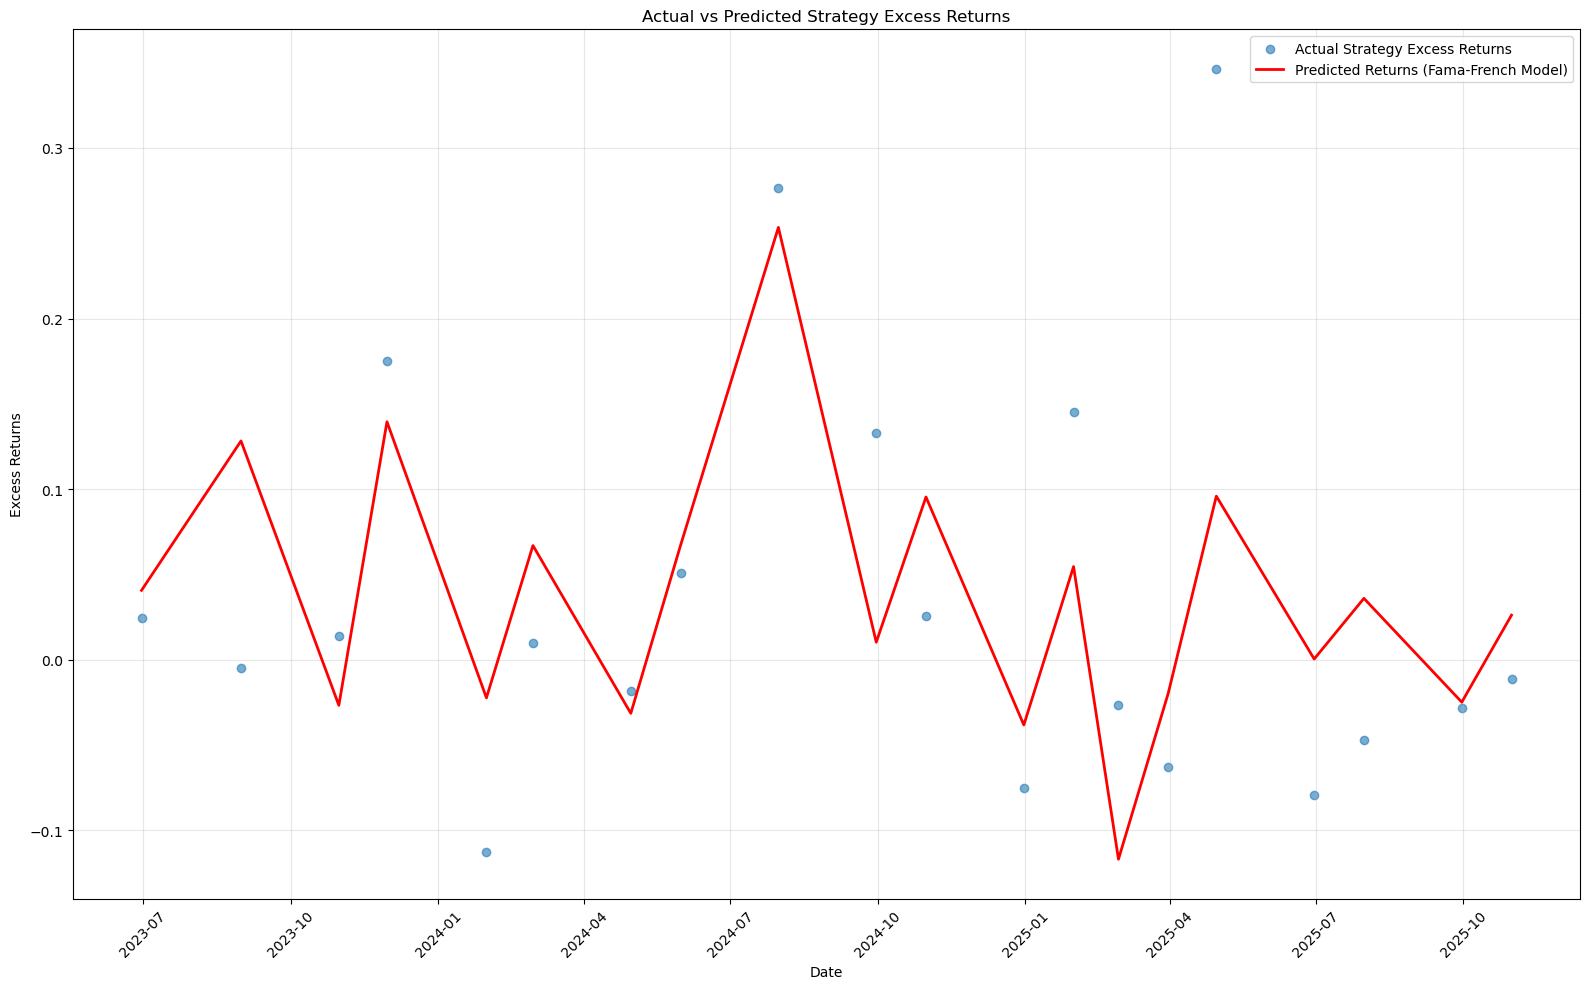

In [101]:
# Plot actual vs predicted strategy returns
plt.figure(figsize=(16,10))
plt.scatter(model_data['Date'], y, label='Actual Strategy Excess Returns', alpha=0.6)
plt.plot(model_data['Date'], model.predict(X), color='red', label='Predicted Returns (Fama-French Model)', linewidth=2)
plt.title('Actual vs Predicted Strategy Excess Returns')
plt.xlabel('Date')
plt.ylabel('Excess Returns')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [108]:
# CAPM Model: Single factor (Market)
mod = smf.ols('excess_returns_strategies ~ MKT', model_data)
res = mod.fit()
print("=== CAPM Model (Market Only) ===")
print(res.summary())

# Extract alpha
alpha_monthly_capm = res.params['Intercept']
alpha_annualized_capm = alpha_monthly_capm * 12

# print alphas
print(f"\nCAPM Monthly Alpha: {alpha_monthly_capm:.4f} ({alpha_monthly_capm*100:.2f}%)")
print(f"CAPM Annualized Alpha: {alpha_annualized_capm:.4f} ({alpha_annualized_capm*100:.2f}%)")

=== CAPM Model (Market Only) ===
                                OLS Regression Results                               
Dep. Variable:     excess_returns_strategies   R-squared:                       0.065
Model:                                   OLS   Adj. R-squared:                  0.013
Method:                        Least Squares   F-statistic:                     1.255
Date:                       Mon, 29 Dec 2025   Prob (F-statistic):              0.277
Time:                               15:29:27   Log-Likelihood:                 15.133
No. Observations:                         20   AIC:                            -26.27
Df Residuals:                             18   BIC:                            -24.27
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

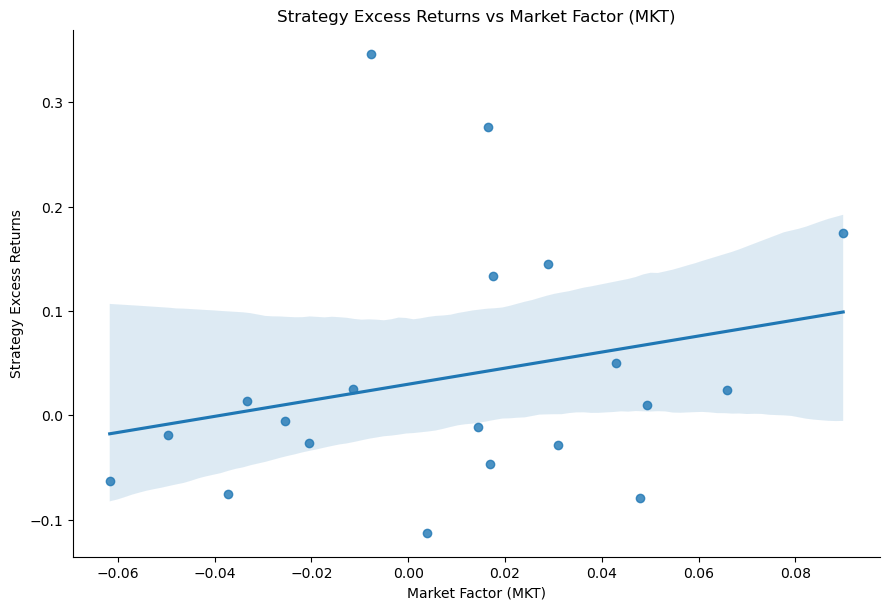

In [103]:
# Scatter Regression Plot: Strategy excess returns vs MKT Fama-French factor
sns.lmplot(data=model_data, x='MKT', y='excess_returns_strategies', height=6, aspect=1.5)
plt.title('Strategy Excess Returns vs Market Factor (MKT)')
plt.xlabel('Market Factor (MKT)')
plt.ylabel('Strategy Excess Returns')
plt.show()

In [104]:
# Fama-French 4-Factor Model
mod = smf.ols('excess_returns_strategies ~ MKT + HML + SMB + UMD', model_data)
res = mod.fit()
print("=== Fama-French 4-Factor Model ===")
print(res.summary())

=== Fama-French 4-Factor Model ===
                                OLS Regression Results                               
Dep. Variable:     excess_returns_strategies   R-squared:                       0.397
Model:                                   OLS   Adj. R-squared:                  0.236
Method:                        Least Squares   F-statistic:                     2.470
Date:                       Mon, 29 Dec 2025   Prob (F-statistic):             0.0895
Time:                               15:27:47   Log-Likelihood:                 19.518
No. Observations:                         20   AIC:                            -29.04
Df Residuals:                             15   BIC:                            -24.06
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

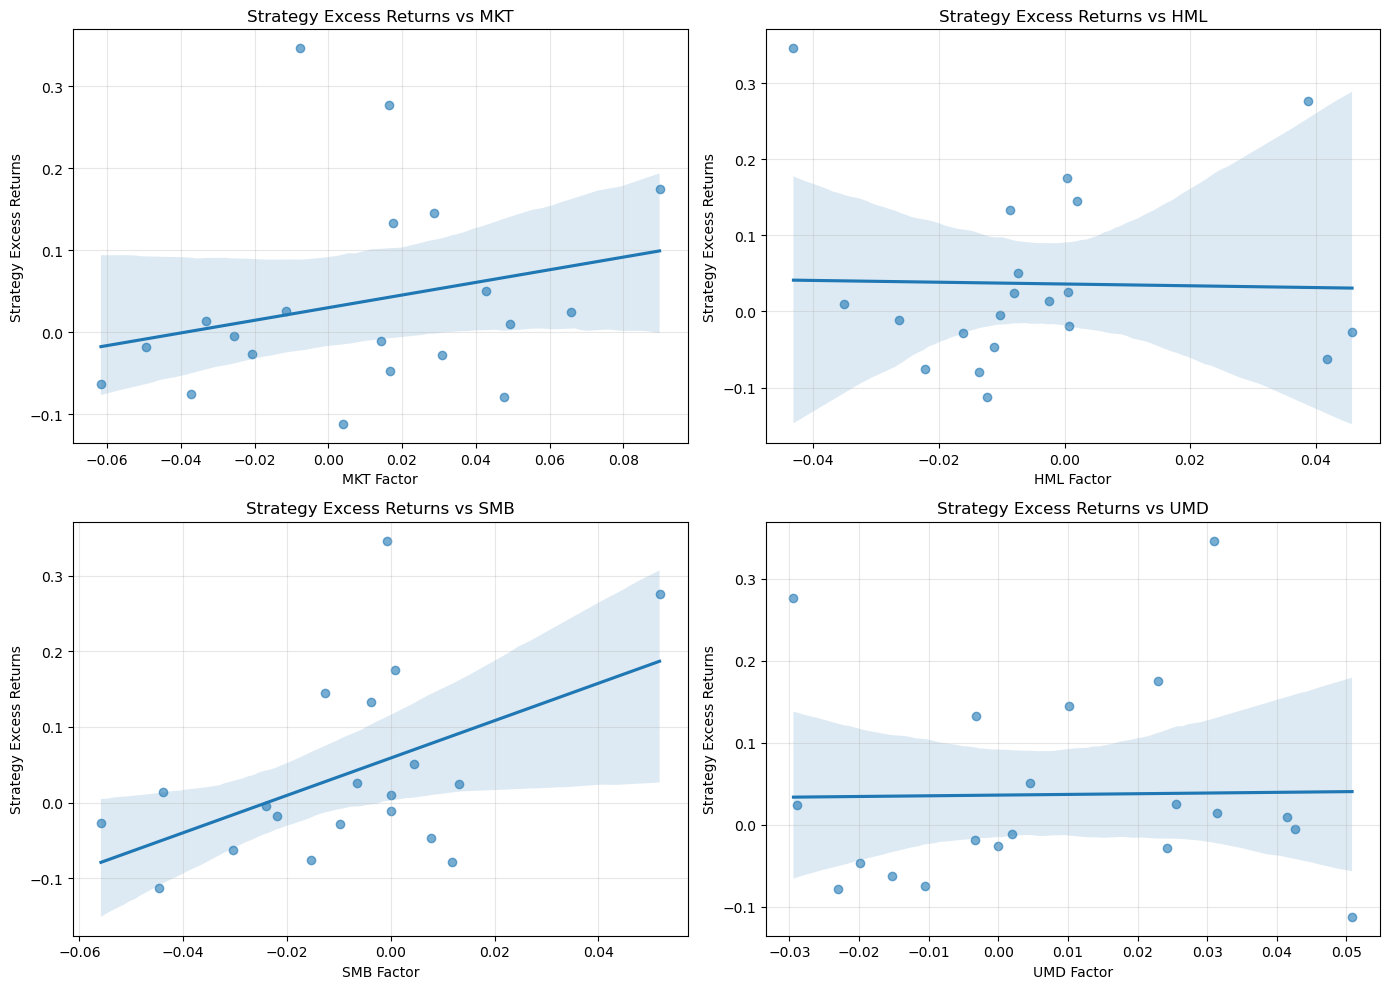

In [105]:
# Scatter Regression Plot: Strategy excess returns vs 4-Factor Model factors
factors = ['MKT', 'HML', 'SMB', 'UMD']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, factor in enumerate(factors):
    ax = axes[idx]
    sns.regplot(data=model_data, x=factor, y='excess_returns_strategies', ax=ax, scatter_kws={'alpha': 0.6})
    ax.set_title(f'Strategy Excess Returns vs {factor}')
    ax.set_xlabel(f'{factor} Factor')
    ax.set_ylabel('Strategy Excess Returns')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [106]:
# Regression: monthly_returns_strategies vs FF Factors
regression_formula = 'monthly_returns_strategies ~ MKT + HML + SMB + UMD + QMJ + BAB'
model = smf.ols(formula=regression_formula, data=model_data).fit()

# Print the regression results
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     monthly_returns_strategies   R-squared:                       0.457
Model:                                    OLS   Adj. R-squared:                  0.206
Method:                         Least Squares   F-statistic:                     1.820
Date:                        Mon, 29 Dec 2025   Prob (F-statistic):              0.172
Time:                                15:27:48   Log-Likelihood:                 20.546
No. Observations:                          20   AIC:                            -27.09
Df Residuals:                              13   BIC:                            -20.12
Df Model:                                   6                                         
Covariance Type:                    nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

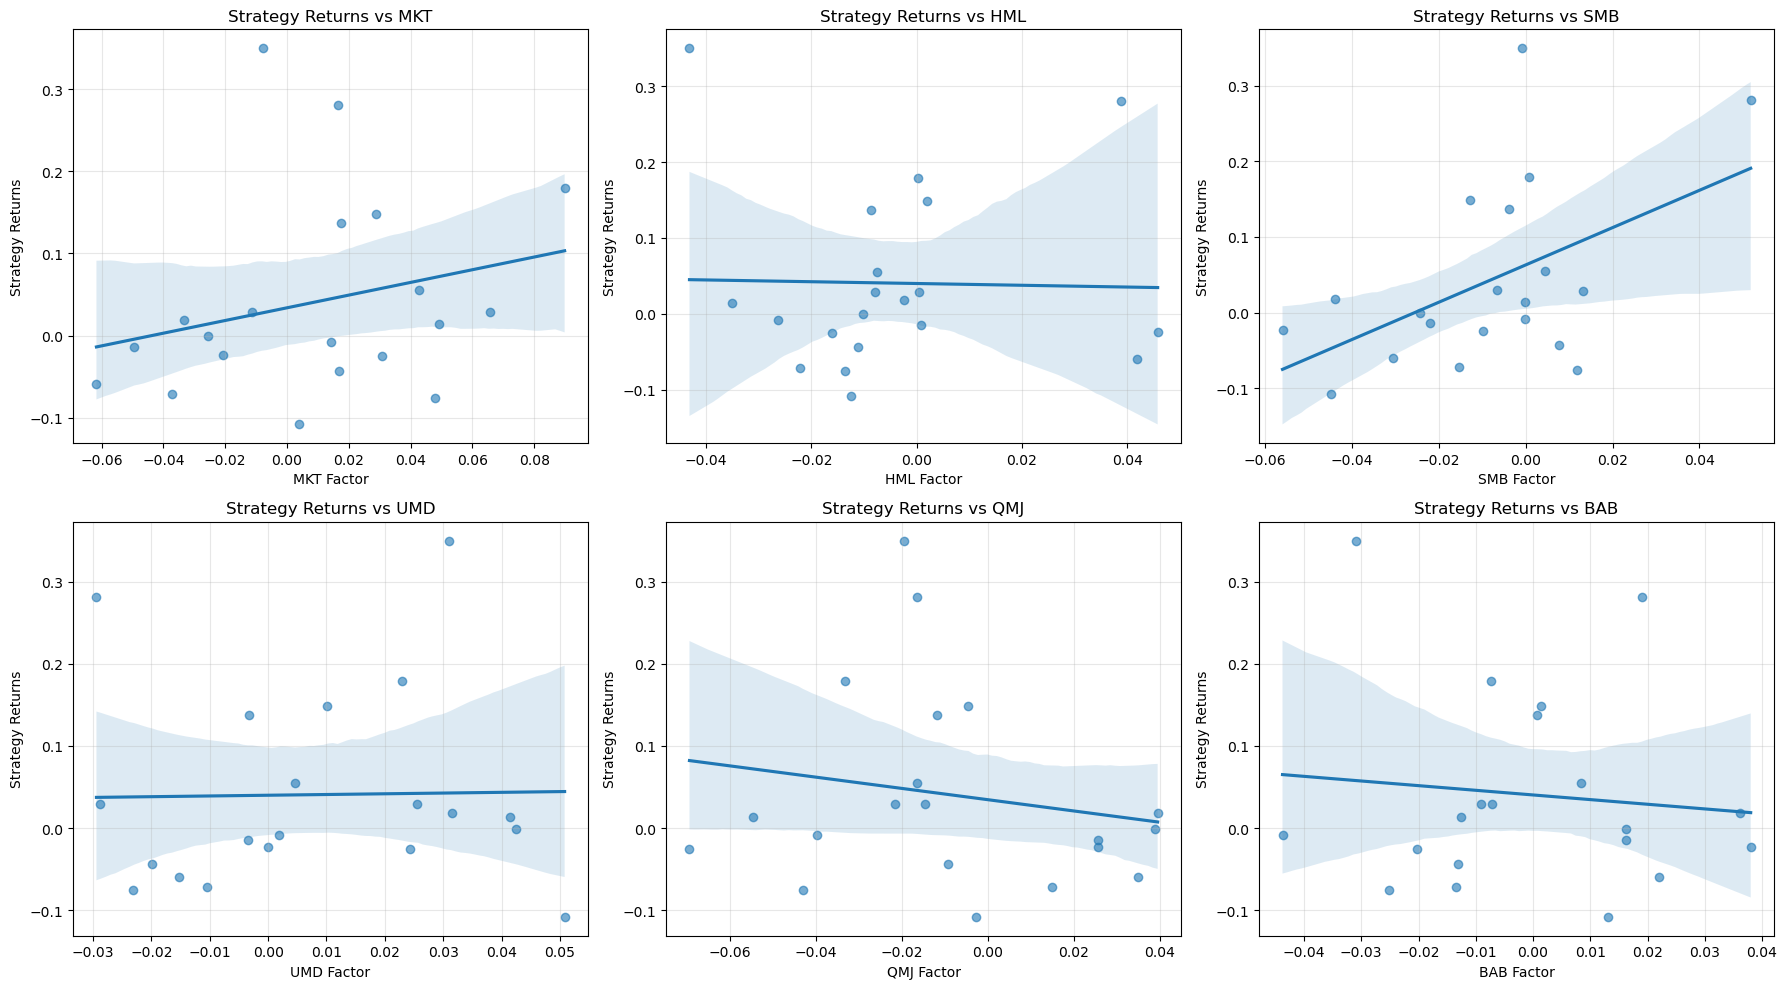

In [107]:
# Scatter Regression Plot: monthly_returns_strategies vs all Fama-French factors
factors = ['MKT', 'HML', 'SMB', 'UMD', 'QMJ', 'BAB']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, factor in enumerate(factors):
    ax = axes[idx]
    sns.regplot(data=model_data, x=factor, y='monthly_returns_strategies', ax=ax, scatter_kws={'alpha': 0.6})
    ax.set_title(f'Strategy Returns vs {factor}')
    ax.set_xlabel(f'{factor} Factor')
    ax.set_ylabel('Strategy Returns')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()